In [1]:

import numpy as np

def generate_pressure_dataset(
    times_s=None,
    glucose_mg_ml=None,
    n_reps=1,
    seed=42,
    # ---- model knobs (you can tune these) ----
    p_max=1200.0,          # upper bound of pressure (mm H2O)
    tau=220.0,             # time constant for saturation (s)
    g_half=12.0,           # glucose half-saturation (mg/mL)
    hill=1.3,              # steepness of glucose effect
    lin_time=0.18,         # small linear drift term to avoid early flatness
    # ---- noise knobs ----
    noise_abs=8.0,         # baseline noise (mm H2O)
    noise_rel=0.035,       # relative noise (fraction of signal)
    # ---- missingness knobs ----
    missing_base=0.00,     # base probability of missing
    missing_pressure_scale=0.00025,  # increases missingness at high pressure
    missing_time_scale=0.00015,      # increases missingness at long times
):
    """
    Generate synthetic CO2 pressure data (mm H2O) as a function of time and initial glucose.
    
    Returns
    -------
    times_s : (T,) array
    glucose_mg_ml : (G,) array
    pressure : (n_reps, T, G) array with np.nan for missing values
    """
    rng = np.random.default_rng(seed)

    if times_s is None:
        # Match your practical scale (30 s to ~510 s, step 30 s)
        times_s = np.arange(30, 541, 30)
    else:
        times_s = np.asarray(times_s, dtype=float)

    if glucose_mg_ml is None:
        # Match your measured conditions, plus allow extension later if desired
        glucose_mg_ml = np.array([5, 10, 20, 40], dtype=float)
    else:
        glucose_mg_ml = np.asarray(glucose_mg_ml, dtype=float)

    T = times_s.size
    G = glucose_mg_ml.size

    # --- Glucose effect: saturating (diminishing returns), Hill-like ---
    # f_g in [0, 1)
    f_g = (glucose_mg_ml**hill) / (g_half**hill + glucose_mg_ml**hill)

    # --- Time effect: saturating growth + small drift ---
    # f_t in [0, ~1]
    f_t = 1.0 - np.exp(-times_s / tau)
    f_t = np.clip(f_t + lin_time * (times_s / times_s.max()), 0, 1.25)

    # Combine: pressure baseline structure
    # Shape (T, G)
    P_mean = p_max * np.outer(f_t, f_g)

    # Add mild curvature to mimic biology / inhibition at very high signal:
    # compress near the top end
    P_mean = P_mean * (1.0 - 0.10 * (P_mean / p_max)**2)
    P_mean = np.clip(P_mean, 0, p_max)

    # Replicates with heteroscedastic noise (abs + relative)
    pressure = np.empty((n_reps, T, G), dtype=float)

    for r in range(n_reps):
        eps = rng.normal(0.0, 1.0, size=(T, G))
        sigma = noise_abs + noise_rel * P_mean
        P = P_mean + sigma * eps

        # enforce monotonic-ish increase with time (optional, realism)
        # allow slight dips due to noise by not forcing strict monotonicity
        P = np.clip(P, 0, None)

        # Missingness: more likely at high pressure and long times
        p_miss = (
            missing_base
            + missing_pressure_scale * P
            + missing_time_scale * (times_s[:, None])
        )
        p_miss = np.clip(p_miss, 0, 0.35)  # cap so we don't wipe out data

        miss_mask = rng.uniform(0, 1, size=(T, G)) < p_miss

        # Also mimic your pattern: later timepoints missing for higher glucose
        # (soft rule; keep it probabilistic)
        high_g = glucose_mg_ml[None, :] >= 20
        late_t = times_s[:, None] >= 270
        miss_mask |= (rng.uniform(0, 1, size=(T, G)) < 0.10) & high_g & late_t

        P[miss_mask] = np.nan
        pressure[r] = P

    return times_s, glucose_mg_ml, pressure


# --- Example usage (quick sanity check) ---
if __name__ == "__main__":
    times, glucose, P = generate_pressure_dataset(n_reps=1, seed=1)
    # Print a small excerpt (first replicate)
    print("times:", times[:5], "...")
    print("glucose:", glucose)
    print("pressure (first 5 rows):")
    print(np.round(P[0, :5, :], 1))
    

times: [ 30  60  90 120 150] ...
glucose: [ 5. 10. 20. 40.]
pressure (first 5 rows):
[[ 43.3  81.4   nan 119.6]
 [ 84.9 142.4 196.2 265.4]
 [110.7 197.4 288.6 370.9]
 [124.6 240.  351.4 464.6]
 [158.8 281.1 407.7 522.5]]


In [3]:
import matplotlib.pyplot as plt

def plot_pressure_timecourses(times_s, glucose_mg_ml, pressure, rep=0):
    P = pressure[rep]
    plt.figure()
    for j, g in enumerate(glucose_mg_ml):
        plt.plot(times_s, P[:, j], marker="o", label=f"{g:g} mg/mL")
    plt.xlabel("Time (s)")
    plt.ylabel("Pressure (mm H2O)")
    plt.title("Synthetic CO₂ pressure time-courses")
    plt.legend()
    plt.show()

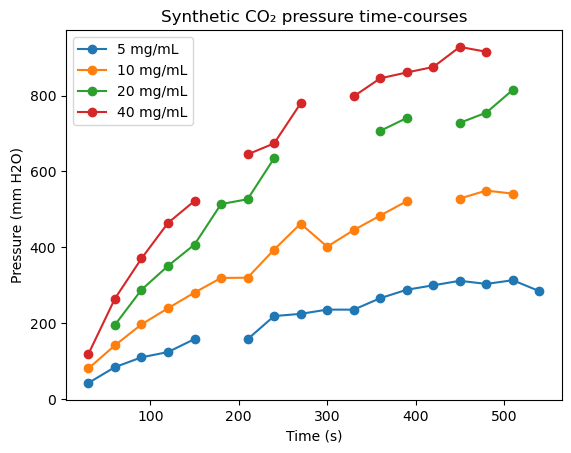

In [4]:
times, glucose, pressure = generate_pressure_dataset(n_reps=1, seed=1)
plot_pressure_timecourses(times, glucose, pressure)